In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

#  Neural Style Transfer & Transfer Learning (VGG19)




# Data set

In [4]:
style_path = '../input/style-transfer-and-object-detection'
style_path_images = [ os.path.join(style_path, image)for image in os.listdir(style_path)]

## load VGG19

In [6]:
input_shape= (400,500)
vgg19= tf.keras.applications.VGG19(include_top= False,
                                  input_shape = input_shape+(3,),
                                  weights= \
                                   '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
#Freeze the pretrained layers
vgg19.trainable= False

print(vgg19.inputs)
print(vgg19.outputs)

[<KerasTensor: shape=(None, 400, 500, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 12, 15, 512) dtype=float32 (created by layer 'block5_pool')>]


### **Step_2: Neural Style Transfer: Computing the Content_Cost & the Style_Cost**

#### **2-1 Computing the Content Cost**

### Make the Generated Image match the Content Image




In [7]:
def content_cost(content_image_model_output, generated_image_model_output):
    """
    Computes the content cost: the difference between the content of the content image C & the content of
    the generated image G.
    
    Arguments:
        content_image_model_output -- the list of the encoding tensors, computed using the pretrained model,\
        the Content image and the layer that have been chosen to represent the Content.The last encoding\
        tensor is the result of the activation layer that have been chosen to extract the content.
  
        generated_image_model_output -- the list of the encoding tensors, computed using the pretrained model,\
        the Generated image and the layer that have been chosen to represent the Content.The last encoding\
        tensor is the result of the activation layer that have been chosen to extract the content.

        
    Returns:
        J_content: a scalar: result of computing content cost.
    
    """
    a_content= content_image_model_output[-1]
    a_generated= generated_image_model_output[-1]
    
    #Retrieve the dimensions from the tensors
    m,n_H,n_W,n_C= a_generated.get_shape().as_list()
    
    #Reshape the tensors so that they have the dimensions (m,n_H*n_W,n_C)
    #we will need this shape later (when computing style cost)
    a_content_unrolled = tf.reshape(a_content,[m,-1,n_C])
    a_generated_unrolled = tf.reshape(a_generated,[m,-1,n_C])
    
    #Compute the cost (retrieved from the paper mentioned above & adjusted to dimensions)
    J_content= (1/(4*n_H*n_W*n_C))* tf.reduce_sum(tf.square(tf.subtract(a_content_unrolled,\
                                                                       a_generated_unrolled)))
    return J_content

In [8]:
# I Choose The layer to represent the content of the image
layers_vgg19=[]
for layer in vgg19.layers:
    layers_vgg19.append(layer.name)
print(layers_vgg19)


['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


##### **Layer block5_conv4 chosen because it captures the high level features of the Content image**

In [9]:
vgg19.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 31, 512) dtype=float32 (created by layer 'block5_conv4')>


#### **2-2 Computing the Style Cost**

#### **Steps**
- Grahm Matrix
- Style Cost
- Total Style cost: Weighted average of style cost of each layer

In [10]:
print(layers_vgg19)

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


In [11]:
# assigning weights to each layer's style cost
style_layers= [('block1_conv1',0.2),('block2_conv1',0.2),('block3_conv1',0.2), ('block4_conv1',0.2),
              ('block5_conv1',0.2)]

In [12]:
#Define the gram_matrix:

def gram_matrix(M):
    
    """
    Computes the gram_matrix of a given matrix
    
    Argument:
        M --  matrix of shape(n_C, n_H*n_W)
    
    Returns:
        Gram_matrix: Gram matrix of M of shape (n_C,n_C)
    """
    
    Gram_matrix= tf.matmul(M, tf.transpose(M))
    return Gram_matrix

In [13]:
# Define the function :one_layer_style_cost,that computes the Style cost for one layer

def one_layer_style_cost(a_style_layer, a_generated_layer):
    """
    Computes the Style cost for one hidden layer: it computes the difference between two gram_matrix\
    gram_matrix of Style image S and gram_matrix of Generated image G.
    
    Arguments:
        a_style_layer -- a tensor of dimensions (1, n_H, n_W, n_C): hidden layer activations of the\
        style image
    
        a_generated_layer -- a tensor of dimensions (1, n_H, n_W, n_C): hidden layer activations of the\
        generated image
    
    Returns: 
        J_style_layer: tensor representing a scalar value(the difference between the gram_matrix\
        of Style image and the gram_matrix of the Generated image)  
    """
    
    #Retrieve the dimensions from the generated image
    m, n_H, n_W, n_C= a_generated_layer.get_shape().as_list()
    
    #Reshape the images to the shape (n_C, n_H*n_W)
    a_style_layer= tf.transpose(tf.reshape(a_style_layer,[-1,n_C]),[1,0])
    a_generated_layer= tf.transpose(tf.reshape(a_generated_layer,[-1,n_C]), [1,0])
    
    #Compute the gram matrix of the two layers
    gram_style = gram_matrix(a_style_layer)
    gram_gen= gram_matrix(a_generated_layer)
    
    #Compute the cost from the original paper mentioned above (in the beginning)
    J_style_layer= (1/(4*n_C**2*(n_H*n_W)**2))*tf.reduce_sum(tf.square(tf.subtract(gram_style,gram_gen)))
    
    return J_style_layer

In [14]:
# Define the function : style_cost, that computes the style_cost for several layers and merges them...

def style_cost(style_image_model_output, generated_image_model_output, style_layers= style_layers):
    """
    Computes the 
    Arguments:
    
        style_image_model_output -- the list of the encoding tensors, computed using the pretrained model,\
        the Style image and the layers that have been chosen to extract the Style.

        generated_image_model_output -- the list of the encoding tensors, computed using the pretrained\
        model, the Generated image and the layers that have been chosen to extract the Style.
    
        Style_layers -- list containing the tuples of the layers that have been chosen to extract\
        the Style and the weights of each of them.
    
    Returns:
        J_style: tensor representing a scalar value (coming form computing the style_cost for each\
        layer that have been chosen to extract the Style.
    """
    J_style= 0
    #exclude the first element, because it is the array of the input image (of the model)
    style_activations= style_image_model_output[1:]
    generated_activations= generated_image_model_output[1:]
    
    #retrieve the number of activations layers, chosen to extract the Style
    num_layers = len(style_activations)
    
    for i, tuple_name_weight in zip(range(num_layers), style_layers):
        style_cost_layer= one_layer_style_cost(style_activations[i],generated_activations[i])
        style_cost_layer *= tuple_name_weight[1]
        J_style += style_cost_layer
    return J_style

#### **2-3 Computing the Total Cost**

In [15]:
def total_cost(J_content,J_style,alpha=10, beta=40):
    """
    Computes the total cost function.
    
    Arguments:
        J_content -- content cost computed above by the function content_cost.
        J_style -- style cost computed by the function style cost.
        alpha: hyperparameter weighting the importance of the content cost.
        beta: hyperparameter weighting the importance of the style cost
    
    Returns:
        J_total: the total cost.
    
    """
    J_total= alpha* J_content + beta* J_style
    return J_total

### **Step_3: Implementing Neural Style Transfer**

- **Load a Content Image**

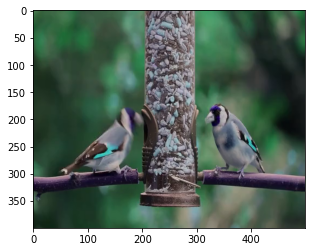

In [16]:
import cv2

# Opens the Video file
all_frames = []
cap= cv2.VideoCapture('../input/goldfincheseating/Video_Of_Goldfinches_Eating-1.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    temp = np.array(frame)
    temp = np.reshape(temp, ((1,)+ temp.shape))
    temp = tf.constant(np.array(temp))
    all_frames.append(temp)
    i+=1

cap.release()
# all_frames = all_frames
# print(all_frames.shape)
plt.imshow(all_frames[0][0])

- **Load a Style Image**

TypeError: imsave() missing 1 required positional argument: 'arr'

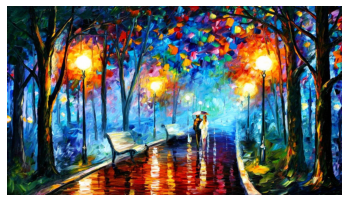

In [22]:
image= Image.open(os.path.join(style_path,'Wallpapers-famous-painting-artist-painter-brush-oil-on-.jpg' ))
style_image_arr= np.array(image)
plt.axis("off")
plt.imshow(style_image_arr)


In [17]:
arr_style_image =tf.image.random_crop(style_image_arr,[400, 500, 3]) 
#The tensor of the style image
style_image= tf.constant(np.reshape(arr_style_image.numpy(),(1,)+(400,500,3)))
print(style_image.shape)

(1, 400, 500, 3)


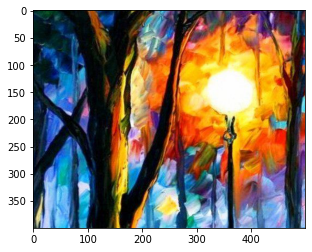

In [18]:
plt.imshow(style_image[0].numpy())

- **Initialize the image to be Generated**

In [19]:
# print("Content image, dtype: {}".format(content_image[0].numpy().dtype))
print("Content image, dtype: {}".format(all_frames[0].numpy().dtype))
print("Style image, dtype: {}".format(style_image[0].numpy().dtype))

Content image, dtype: uint8
Style image, dtype: uint8


In [20]:
#I initialize the generated image as a noisy image 
temp = []
for i in all_frames:
    temp.append(tf.Variable(tf.image.convert_image_dtype(i, tf.float32)))

generated_image = temp
print(len(generated_image))
# plt.imshow(tf.image.convert_image_dtype(generated_image, tf.uint8)[0])

25


- **Create a Model from the Vgg19 model that gives the outputs of some chosen hidden layers**

In [21]:
def mini_vgg19(layers):
    """
    Creates a mini model from the Vgg19 model, given some hidden layers
    Argument:
        layers -- a list composed of tuples :(layer_name, weight)
    """
    mini_model_outputs= [vgg19.get_layer(layer_weight[0]).output for layer_weight in layers]
    model= tf.keras.Model(inputs= vgg19.input, outputs= mini_model_outputs)
    return model

- **Get the list of encoders for content, style and generated images**

In [22]:
content_layer= [('block5_conv4',1)]
mini_vgg19_model= mini_vgg19(style_layers+ content_layer)

In [24]:
style_image= tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))

### **Step_4: Train the model & Generate the final images**

In [26]:
#visualization 

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [27]:
#Helper function 
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [28]:
#Define train_step

def train_step_one(image, C_list_vgg19_encoders, S_list_vgg19_encoders, G_list_vgg19_encoders):
    with tf.GradientTape() as tape:
        aciv_G = mini_vgg19_model(image)
        J_content= content_cost(C_list_vgg19_encoders,aciv_G)
        J_style= style_cost(S_list_vgg19_encoders,aciv_G)
        J_total= total_cost(J_content, J_style)
   
    grad = tape.gradient(J_total, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


(1, 400, 500, 3)
Train step: 4000
Total time: 253.8


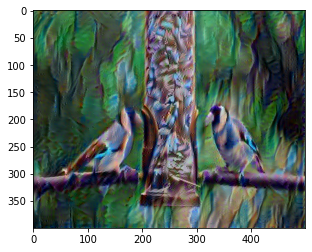

(1, 400, 500, 3)
Train step: 4000
Total time: 252.3


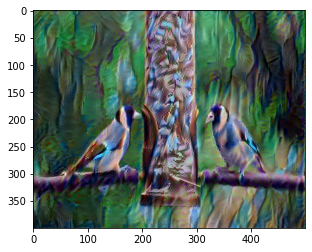

(1, 400, 500, 3)
Train step: 4000
Total time: 252.0


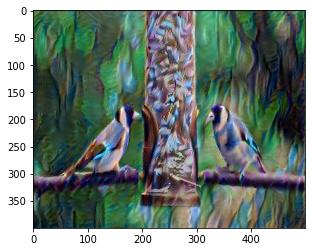

(1, 400, 500, 3)
Train step: 4000
Total time: 251.6


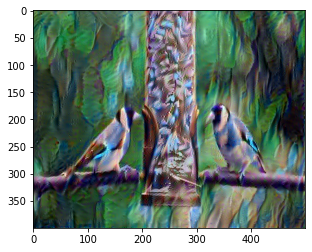

(1, 400, 500, 3)
Train step: 4000
Total time: 251.8


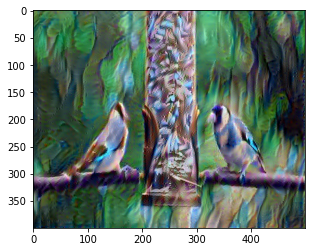

(1, 400, 500, 3)
Train step: 4000
Total time: 251.7


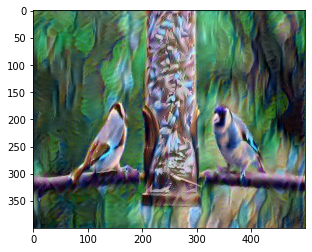

(1, 400, 500, 3)
Train step: 4000
Total time: 251.6


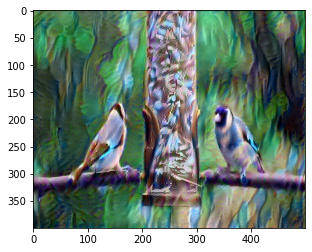

(1, 400, 500, 3)
Train step: 4000
Total time: 251.5


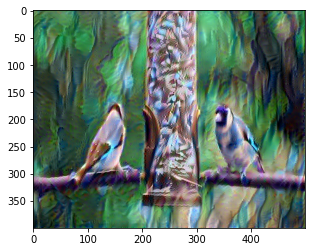

(1, 400, 500, 3)
Train step: 4000
Total time: 251.4


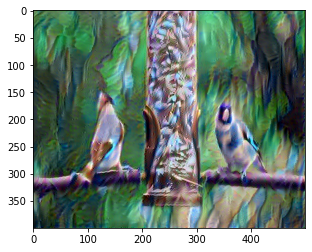

(1, 400, 500, 3)
Train step: 4000
Total time: 251.6


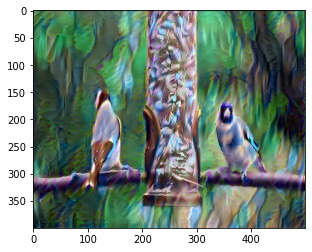

(1, 400, 500, 3)
Train step: 4000
Total time: 251.4


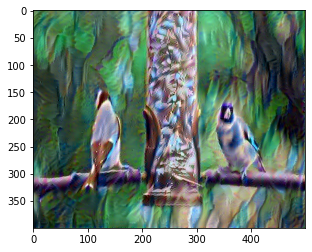

(1, 400, 500, 3)
Train step: 4000
Total time: 251.9


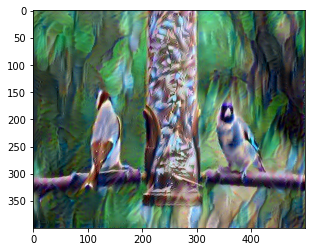

(1, 400, 500, 3)
Train step: 4000
Total time: 252.2


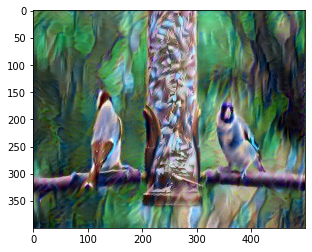

(1, 400, 500, 3)
Train step: 4000
Total time: 252.9


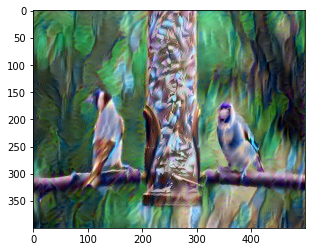

(1, 400, 500, 3)
Train step: 4000
Total time: 251.4


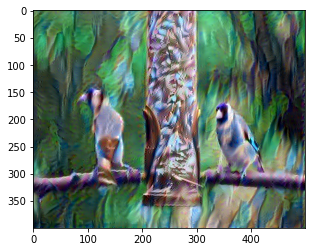

(1, 400, 500, 3)
Train step: 4000
Total time: 251.5


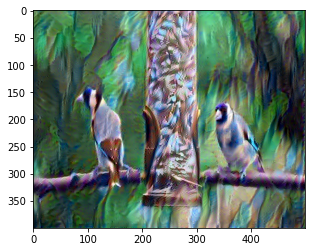

(1, 400, 500, 3)
Train step: 4000
Total time: 251.4


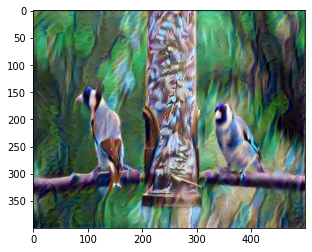

(1, 400, 500, 3)
Train step: 4000
Total time: 252.0


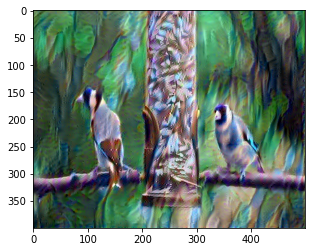

(1, 400, 500, 3)
Train step: 4000
Total time: 251.9


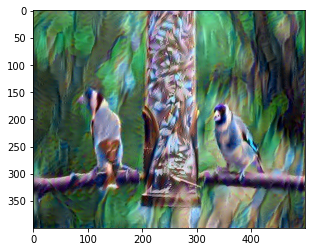

(1, 400, 500, 3)
Train step: 4000
Total time: 251.5


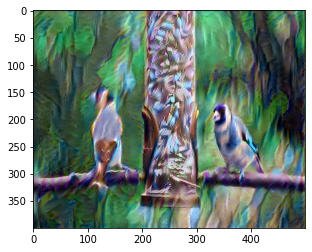

(1, 400, 500, 3)
Train step: 4000
Total time: 251.5


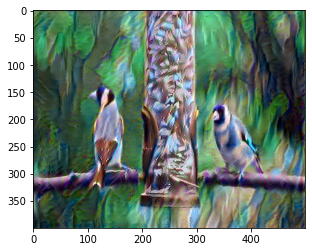

(1, 400, 500, 3)
Train step: 4000
Total time: 251.4


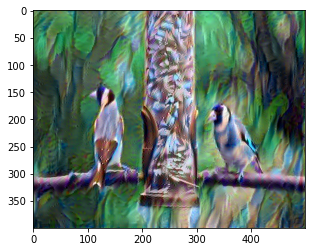

(1, 400, 500, 3)
Train step: 4000
Total time: 251.5


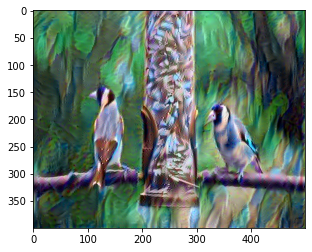

(1, 400, 500, 3)
Train step: 4000
Total time: 251.4


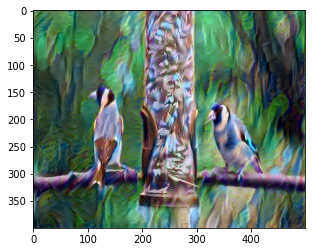

(1, 400, 500, 3)
Train step: 4000
Total time: 251.8


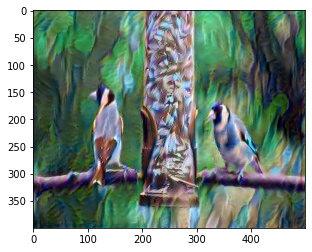

In [29]:
def training_frame(generated_image, C_list_vgg19_encoders, S_list_vgg19_encoders, G_list_vgg19_encoders):
    #optimization:  
    import time 
    start= time.time()
    epochs= 40
    steps_per_epoch= 100
    step = 0
    for i in range(epochs):
        for j in range(steps_per_epoch):
            step +=1
            train_step_one(generated_image, C_list_vgg19_encoders, S_list_vgg19_encoders, G_list_vgg19_encoders)
    print("Train step: {}".format(step))
    image = tensor_to_image(generated_image)
    end= time.time()
    print("Total time: {:.1f}".format(end-start))
    return image

output_frames = []

for indx in range(len(all_frames)):
    #The optimizer
    opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)
    print(generated_image[indx].shape)
    C_list_vgg19_encoders= mini_vgg19_model(all_frames[indx])
    #create models: 
    S_list_vgg19_encoders= mini_vgg19_model(style_image) 
    G_list_vgg19_encoders= mini_vgg19_model(generated_image[indx])
    img = training_frame(generated_image[indx], C_list_vgg19_encoders, S_list_vgg19_encoders, G_list_vgg19_encoders)
    plt.imshow(img)
    plt.show()
    output_frames.append(img)


In [69]:
out = cv2.VideoWriter('comp.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 25, (1000,400))

for x in range(10):
    
    for i in range(len(output_frames)):


        # Write the frame into the file 'output.avi'
    #     tem = np.array(i)
    #     tem = temp.reshape(tem.shape[1], tem.shape[2], tem.shape[3])

        tem = np.array(output_frames[i])

        tem2= np.array(all_frames[i])
        tem2 = tem2.reshape(tem2.shape[1], tem2.shape[2], tem2.shape[3])
    #     print(tem.shape, tem2.shape)
    #     print(tem.dtype, tem2.dtype)
        tem = np.concatenate((tem2, tem), axis = 1)
        print(tem.shape)
        out.write(tem)
# #     # Display the resulting frame    
#     plt.imshow(tem)

out.release()

(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000, 3)
(400, 1000

In [ ]:
# show images
for i in output_frames:
    plt.figure()
    plt.imshow(i)
    
    
    
